In [541]:
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime
from contextlib import contextmanager
from typing import Any
import matplotlib.pyplot as plt

In [542]:
# SQL Database helpers

db = sqlite3.connect('Database') if not 'db' in locals() else db

def dict_factory(cursor, row):
    d = {}
    for idx, col in enumerate(cursor.description):
        d[col[0]] = row[idx]
    return d
    
db.row_factory = dict_factory

@contextmanager
def cursor():
    cursor_ = None
    try:
        cursor_ = db.cursor()
        yield cursor_
    finally:
        if cursor_:
            cursor_.close()


def table_exists(table_name: str) -> bool:
    with cursor() as c:
        try:
            c.execute(f'SELECT 1 FROM "{table_name}"')
            return True
        except sqlite3.OperationalError:
            return False


In [543]:
electricity = pd.read_csv('data/electricity.csv') \
    if 'electricity' not in locals() else electricity

daily_weather = pd.read_parquet('data/daily_weather.parquet') \
    if 'daily_weather' not in locals() else daily_weather

cities_in_countries = pd.read_csv('data/cities.csv') \
    if 'cities_in_countries' not in locals() else cities_in_countries

In [544]:
if not table_exists('daily_weather_raw'):
    daily_weather.to_sql('daily_weather_raw', db, if_exists='replace')
    
if not table_exists('weather_cities'): 
    cities_in_countries.to_sql('weather_cities', db, if_exists='replace')

if not table_exists('electricity'): 
    electricity.to_sql('electricity', db, if_exists='replace')

In [545]:
# grouping weather data by month - to join with electricity
with cursor() as c:
    try:
        c.execute('ALTER TABLE daily_weather_raw ADD COLUMN year INT;')
        c.execute('ALTER TABLE daily_weather_raw ADD COLUMN month INT;')
        c.execute('UPDATE daily_weather_raw SET year=strftime("%Y", date), month=strftime("%m", date);')
        c.execute('DELETE FROM daily_weather_raw WHERE year < 2010 OR year > 2018;')
    except:
        pass # už se stalo

In [546]:
# Missing values treatment:
average_temps = """
    SELECT 
        country, 
        month, 
        AVG(max_temp_c) AS max, 
        AVG(min_temp_c) AS min,
        AVG(avg_sea_level_pres_hpa) AS pressure,
        AVG(precipitation_mm) AS precipitation
    FROM daily_weather_raw
    JOIN weather_cities ON weather_cities.station_id = daily_weather_raw.station_id
    GROUP BY country, month
"""

complete_weather_query = f"""
    SELECT 
        c.country,
        w.year,
        w.month,
        w.season,
        AVG(avg_temp_c) AS avg_temp_c,
        COALESCE(MAX(max_temp_c), _avg.max) AS max_temp_c,
        COALESCE(MIN(min_temp_c), _avg.min) AS min_temp_c,
        COALESCE(AVG(avg_sea_level_pres_hpa), _avg.pressure) AS avg_sealevel_pressure_hpa,
        COALESCE(AVG(precipitation_mm), _avg.precipitation) AS avg_daily_precipitation_mm,
        AVG(sunshine_total_min) AS avg_sunshine_min,
        SUM(sunshine_total_min) AS total_sunshine_min,
        AVG(snow_depth_mm) AS avg_snow_depth_mm
    FROM daily_weather_raw w
    JOIN weather_cities c ON c.station_id = w.station_id
    LEFT JOIN ({average_temps}) _avg ON (
        _avg.country = c.country
        AND _avg.month = w.month
    )
    GROUP BY c.country, w.year, w.month
"""

with cursor() as c:
    limit = 5
    print(pd.DataFrame(c.execute(f'{complete_weather_query} LIMIT ?;', [limit]).fetchall()))

       country  year  month  season  avg_temp_c  max_temp_c  min_temp_c  \
0  Afghanistan  2010      1  Winter    4.236301        22.8       -18.0   
1  Afghanistan  2010      2  Winter    3.833871        26.7       -19.5   
2  Afghanistan  2010      3  Spring   11.642581        34.8        -6.5   
3  Afghanistan  2010      4  Spring   17.192517        34.8        -5.3   
4  Afghanistan  2010      5  Spring   20.677703        39.8         2.5   

  avg_sealevel_pressure_hpa  avg_daily_precipitation_mm avg_sunshine_min  \
0                      None                    2.134545             None   
1                      None                    4.703774             None   
2                      None                    2.781538             None   
3                      None                    3.335593             None   
4                      None                    3.452727             None   

  total_sunshine_min  avg_snow_depth_mm  
0               None         106.631579  
1       

In [547]:
# read and load population datasets

if not table_exists('population'):
    population = pd.read_csv('data/population_total_long.csv')
    population.to_sql('population', db, if_exists='replace')

if not table_exists('pop_female_perc'):
    pop_female_perc = pd.read_csv('data/population_female_percentage_long.csv')
    pop_female_perc.to_sql('pop_female_perc', db, if_exists='replace')

if not table_exists('pop_density'):
    pop_density = pd.read_csv('data/population_density_long.csv')
    pop_density.to_sql('pop_density', db, if_exists='replace')

if not table_exists('pop_below_14'):
    pop_below_14 = pd.read_csv('data/population_below_age_14_percentage_long.csv')
    pop_below_14.to_sql('pop_below_14', db, if_exists='replace')

if not table_exists('pop_above_65'):
    pop_above_65 = pd.read_csv('data/population_above_age_65_percentage_long.csv')
    pop_above_65.to_sql('pop_above_65', db, if_exists='replace')

In [548]:
# Odvozené sloupce: male_perc, population_working_age

population_complete = """
    SELECT 
        p."Country Name" AS country,
        p.Year AS year,
        female.Count AS female_perc,
        (100 - female.Count) AS male_perc,
        density.Count AS population_density,
        below14.Count AS population_below_14_perc,
        above65.Count AS population_above_65_perc,
        (100 - below14.Count - above65.Count) AS population_working_age_perc
    FROM population p
    JOIN pop_female_perc female ON (
        female."Country Name" = p."Country Name" AND female.Year = p.Year
    )
    JOIN pop_density density ON (
        density."Country Name" = p."Country Name" AND density.Year = p.Year
    )
    JOIN pop_below_14 below14 ON (
        below14."Country Name" = p."Country Name" AND below14.Year = p.Year
    )
    JOIN pop_above_65 above65 ON (
        above65."Country Name" = p."Country Name" AND above65.Year = p.Year
    )
"""

with cursor() as c:
    limit = 5
    print(pd.DataFrame(c.execute(f'{population_complete} LIMIT ?;', [limit]).fetchall()))

                country  year  female_perc  male_perc  population_density  \
0                 Aruba  1961           50         50                 307   
1           Afghanistan  1961           48         52                  14   
2                Angola  1961           49         51                   4   
3               Albania  1961           48         52                  60   
4  United Arab Emirates  1961           48         52                   1   

   population_below_14_perc  population_above_65_perc  \
0                        43                         2   
1                        42                         2   
2                        42                         3   
3                        40                         5   
4                        43                         3   

   population_working_age_perc  
0                           55  
1                           56  
2                           55  
3                           55  
4                           5

In [549]:
def select_product(product: str|list[str]) -> tuple[str, list]:
    if type(product) == str:
        product = [product]

    placeholders = ', '.join(['?' for _ in range(len(product))])

    return (f"""
        SELECT
            CONCAT_WS("-", e.COUNTRY, e.YEAR, e.MONTH) AS key,
            e.COUNTRY,
            e.YEAR,
            e.MONTH,
            COALESCE(SUM(e.VALUE), 0) AS value
        FROM electricity e 
        WHERE e.PRODUCT IN ({placeholders})
        GROUP BY e.COUNTRY, e.YEAR, e.MONTH
    """, product)
    
def group_by_year(data: list[dict]) -> dict[int, Any]:
    by_year = {}
    for row in data:
        key = row['year']
        if key not in by_year:
            by_year[key] = []
        by_year[row['year']].append(row['value'])

    return by_year

In [550]:
# Jsou sloupce s názvy "Total ..., renewables, ..." agregace, nebo je některé země uvádějí pouze agregace 
# místo konkrétních zdrojů el. energie?

with cursor() as c:
    # "Total combustible fuels" je agregace - nebereme v potaz
    print('Total combustible fuels', c.execute("""
        SELECT COUNTRY, COUNT(*) 
        FROM electricity 
        WHERE PRODUCT IN ("Total combustible fuels", "Coal") 
        GROUP BY COUNTRY, YEAR, MONTH 
        HAVING COUNT(*) > 1
        LIMIT 5
    """).fetchall())

    # "Non renewables" není
    print('Non renewables', c.execute("""
        SELECT COUNTRY, COUNT(*) 
        FROM electricity 
        WHERE PRODUCT IN ("Non renewables", "Coal")
        GROUP BY COUNTRY, YEAR, MONTH 
        HAVING COUNT(*) > 1
        LIMIT 5
    """).fetchall())

    # "Renewables" je 
    print('Renewables', c.execute("""
        SELECT COUNTRY, COUNT(*) 
        FROM electricity 
        WHERE PRODUCT IN ("Renewables", "Solar")
        GROUP BY COUNTRY, YEAR, MONTH 
        HAVING COUNT(*) > 1
        LIMIT 5
    """).fetchall())
    

Total combustible fuels [{'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}]
Non renewables []
Renewables [{'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}, {'COUNTRY': 'Argentina', 'COUNT(*)': 2}]


Vyfiltované (déle používané) hodnoty sloupce _PRODUCT_ z datasetu _electricity_

In [551]:
renewables = ['Hydro', 'Wind', 'Solar', 'Geothermal', 'Combustible renewables', 'Other renewables', 'Other combustible renewables']
non_renewables = ['Coal', 'Oil', 'Natural gas', 'Low carbon', 'Fossil fuels', 'Nuclear']

all_energy_producing_sources = [*renewables, *non_renewables]

total_q, total_p = select_product(all_energy_producing_sources)

def select_product_relative(product: str|list[str]) -> tuple[str, list]:
    product_q, product_p = select_product(product)
    parameters = [*total_p, *product_p]
    query = f"""
        SELECT 
            t.key,
            t.COUNTRY AS country,
            t.YEAR AS year,
            t.MONTH AS month,
            (p.value / t.value) AS value
        FROM ({total_q}) t
        JOIN ({product_q}) p ON t.key = p.key
    """

    return query, parameters

In [552]:
relative_coal, relative_coal_p = select_product_relative('Coal')
relative_nuclear, relative_nuclear_p = select_product_relative('Nuclear')

relative_hydro, relative_hydro_p = select_product_relative('Hydro')
relative_wind, relative_wind_p = select_product_relative('Wind')
relative_solar, relative_solar_p = select_product_relative('Solar')
relative_renewables, relative_renewables_p = select_product_relative(renewables)

parameters = [
    *relative_coal_p,
    *relative_nuclear_p,
    *relative_hydro_p,
    *relative_wind_p,
    *relative_solar_p,
    *relative_renewables_p,
]

def create_join(on_alias: str, query: str, alias: str, kind: str = 'LEFT') -> str:
    return f""" {kind} JOIN ({query}) {alias} ON (
        {alias}.country = {on_alias}.COUNTRY
        AND {alias}.year = {on_alias}.YEAR
        AND {alias}.month = {on_alias}.MONTH
    )"""

complete_data_query = f"""
    SELECT 
        e.COUNTRY AS country,
        e.YEAR AS year,
        e.MONTH AS month,
        
        COALESCE(coal.value, 0) AS coal_perc,
        COALESCE(nuclear.value, 0) AS nuclear_perc,
        
        COALESCE(hydro.value, 0) AS hydro_perc,
        COALESCE(wind.value, 0) AS wind_perc,
        COALESCE(solar.value, 0) AS solar_perc,
        COALESCE(renewables.value, 0) AS renewables_perc,
        w.*,
        pop.*
    FROM electricity e
    JOIN ({population_complete}) pop ON (
        pop.country = e.COUNTRY
        AND pop.year = e.YEAR
    )
    {create_join('e', complete_weather_query, 'w', kind='INNER')}
    
    {create_join('e', relative_coal, 'coal')}
    {create_join('e', relative_nuclear, 'nuclear')}
    
    {create_join('e', relative_hydro, 'hydro')}
    {create_join('e', relative_wind, 'wind')}
    {create_join('e', relative_solar, 'solar')}
    {create_join('e', relative_renewables, 'renewables')}

    GROUP BY e.COUNTRY, e.YEAR, e.MONTH
"""

print('complete data query: ', complete_data_query)

with cursor() as c:
    df = pd.DataFrame(c.execute(f'{complete_data_query};', parameters).fetchall())
    df_orig_ = df.copy()
    
    print('Total countries with values', len(c.execute(f'SELECT DISTINCT country FROM ({complete_data_query});', parameters).fetchall()))

complete data query:  
    SELECT 
        e.COUNTRY AS country,
        e.YEAR AS year,
        e.MONTH AS month,
        
        COALESCE(coal.value, 0) AS coal_perc,
        COALESCE(nuclear.value, 0) AS nuclear_perc,
        
        COALESCE(hydro.value, 0) AS hydro_perc,
        COALESCE(wind.value, 0) AS wind_perc,
        COALESCE(solar.value, 0) AS solar_perc,
        COALESCE(renewables.value, 0) AS renewables_perc,
        w.*,
        pop.*
    FROM electricity e
    JOIN (
    SELECT 
        p."Country Name" AS country,
        p.Year AS year,
        female.Count AS female_perc,
        (100 - female.Count) AS male_perc,
        density.Count AS population_density,
        below14.Count AS population_below_14_perc,
        above65.Count AS population_above_65_perc,
        (100 - below14.Count - above65.Count) AS population_working_age_perc
    FROM population p
    JOIN pop_female_perc female ON (
        female."Country Name" = p."Country Name" AND female.Year = p.Yea

## Missing values treatment

In [553]:
# Drop pro všechny sloupce, které nemají hodnotu ve více než 30 % řádků
df = df_orig_.copy()

missing_col_names = [ column_name for column_name, count_na in df.isna().sum().items() if count_na > (len(df) * 0.3)]
print(f'Before: n_rows: {len(df)}; n_cols: {len(df.columns)}')
print(f'{missing_col_names=}')

for col in missing_col_names:
    df.drop(col, axis='columns', inplace=True)

print(f'After: n_rows: {len(df)}; n_cols: {len(df.columns)}')

df.isna().sum()

Before: n_rows: 3348; n_cols: 24
missing_col_names=['avg_sunshine_min', 'total_sunshine_min', 'avg_snow_depth_mm']
After: n_rows: 3348; n_cols: 21


country                          0
year                             0
month                            0
coal_perc                        0
nuclear_perc                     0
hydro_perc                       0
wind_perc                        0
solar_perc                       0
renewables_perc                  0
season                           0
avg_temp_c                       0
max_temp_c                       0
min_temp_c                       0
avg_sealevel_pressure_hpa      234
avg_daily_precipitation_mm      96
female_perc                      0
male_perc                        0
population_density               0
population_below_14_perc         0
population_above_65_perc         0
population_working_age_perc      0
dtype: int64

In [554]:
missing_under_30_perc = [ col_name for col_name, count in df.isna().sum().items() if count > 0]
print(f'{missing_under_30_perc=}\n')

missing_under_30_perc=['avg_sealevel_pressure_hpa', 'avg_daily_precipitation_mm']



In [555]:
print('max_temp_c countries: \n', df[df['max_temp_c'].isna()][['country', 'year', 'month']])
df['avg_sealevel_pressure_hpa'].fillna(df['avg_sealevel_pressure_hpa'].mean(), inplace=True)
df['avg_daily_precipitation_mm'].fillna(0, inplace=True)

df.isna().sum()

max_temp_c countries: 
 Empty DataFrame
Columns: [country, year, month]
Index: []


country                        0
year                           0
month                          0
coal_perc                      0
nuclear_perc                   0
hydro_perc                     0
wind_perc                      0
solar_perc                     0
renewables_perc                0
season                         0
avg_temp_c                     0
max_temp_c                     0
min_temp_c                     0
avg_sealevel_pressure_hpa      0
avg_daily_precipitation_mm     0
female_perc                    0
male_perc                      0
population_density             0
population_below_14_perc       0
population_above_65_perc       0
population_working_age_perc    0
dtype: int64

## Kategorizace

In [556]:
total_q, total_p = select_product(all_energy_producing_sources)

def relative_energy_source_box(product_name: str|list[str], title: str, ylabel: str, limit_max: float|None = None) -> None:
    energy_source_q, energy_source_p = select_product(product_name)
    parameters = [*total_p, *energy_source_p]
    limit_max_q = f'HAVING (AVG((COALESCE(r.value, 1) / t.value) * 100)) > {limit_max}' if limit_max is not None else ''
    
    query = f"""
        SELECT 
            t.country AS country,
            t.year AS year,
            AVG((COALESCE(r.value, 1) / t.value) * 100) AS value
        FROM ({total_q}) t
        LEFT JOIN ({energy_source_q}) r ON r.key = t.key
        GROUP BY t.country, t.year
        {limit_max_q}
        ORDER BY t.country, t.year
    """
    
    result: dict
    with cursor() as c:   
        result = c.execute(query, parameters).fetchall()

    result = dict(sorted(group_by_year(result).items()))
    
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel('Rok')
    ax.set_ylabel(ylabel)
    ax.boxplot(result.values())
    ax.set_xticklabels(result.keys())

### `coal_perc`

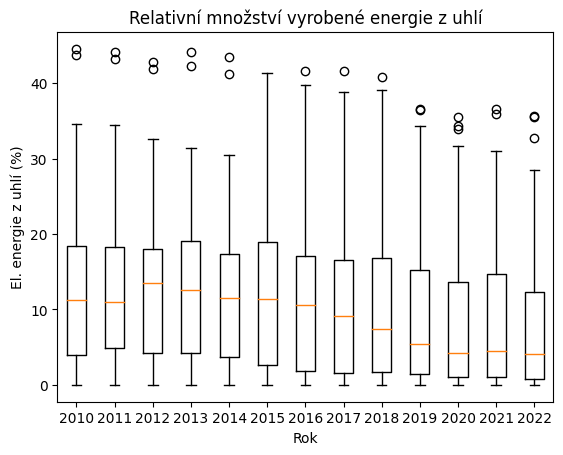

In [557]:
relative_energy_source_box('Coal',
                            title='Relativní množství vyrobené energie z uhlí',
                            ylabel='El. energie z uhlí (%)')

In [558]:
coal_bins = [-np.inf, .05, .1, .2, .3, np.inf]
coal_labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['coal'] = pd.cut(x=df['coal_perc'], bins=coal_bins, labels=coal_labels)
df.drop('coal_perc', axis='columns', inplace=True)

### `nuclear_perc`

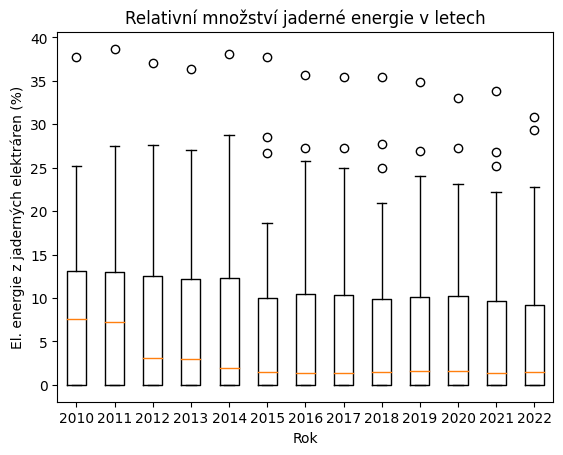

In [559]:
relative_energy_source_box('Nuclear',
                            title='Relativní množství jaderné energie v letech',
                            ylabel='El. energie z jaderných elektráren (%)')

In [560]:
nuclear_bins = [-np.inf, .02, .07, 0.1, 0.25, np.inf]
nuclear_labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['nuclear'] = pd.cut(x=df['nuclear_perc'], bins=nuclear_bins, labels=nuclear_labels)
df.drop('nuclear_perc', axis='columns', inplace=True)

### `hydro_perc`

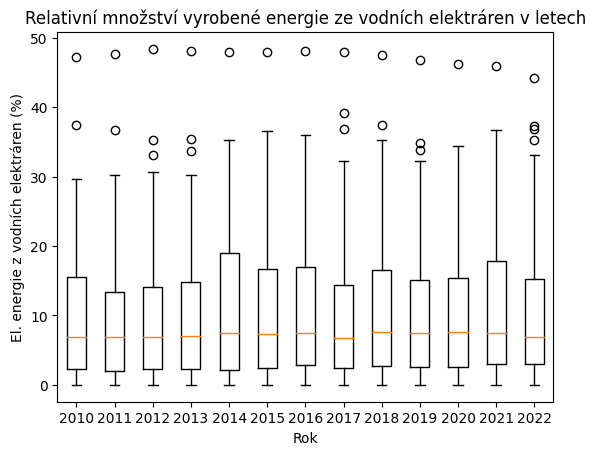

In [561]:
relative_energy_source_box('Hydro',
                            title='Relativní množství vyrobené energie ze vodních elektráren v letech',
                            ylabel='El. energie z vodních elektráren (%)')

In [562]:
hydro_bins = [-np.inf, .03, .07, 0.12, np.inf]
hydro_labels = ['very low or none', 'low', 'medium', 'high']

df['hydro'] = pd.cut(x=df['hydro_perc'], bins=hydro_bins, labels=hydro_labels)
df.drop('hydro_perc', axis='columns', inplace=True)

### `solar_perc`

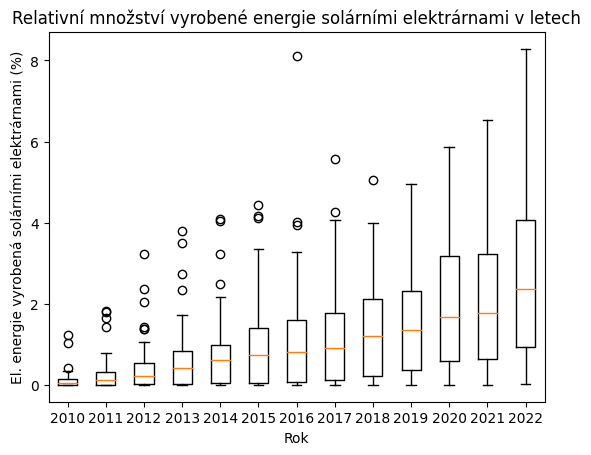

In [563]:
relative_energy_source_box('Solar',
                            title='Relativní množství vyrobené energie solárními elektrárnami v letech',
                            ylabel='El. energie vyrobená solárními elektrárnami (%)')

In [564]:
bins = [-np.inf, .002, .01, .02, .04, np.inf]
labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['solar'] = pd.cut(x=df['solar_perc'], bins=bins, labels=labels)
df.drop('solar_perc', axis='columns', inplace=True)

### `wind_perc`

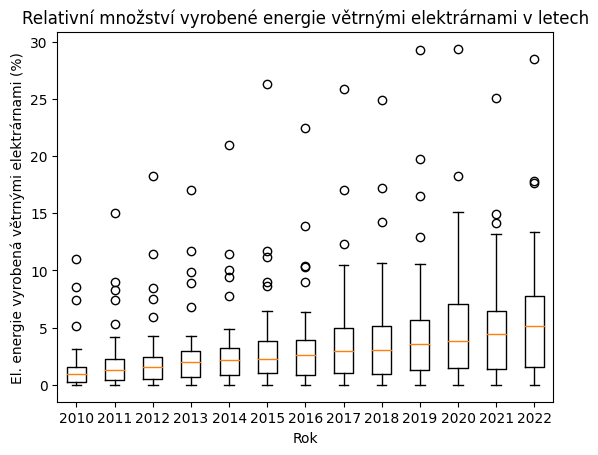

In [565]:
relative_energy_source_box('Wind',
                            title='Relativní množství vyrobené energie větrnými elektrárnami v letech',
                            ylabel='El. energie vyrobená větrnými elektrárnami (%)')

In [566]:
bins = [-np.inf, .01, .02, .2, .5, np.inf]
labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['wind'] = pd.cut(x=df['wind_perc'], bins=bins, labels=labels)
df.drop('wind_perc', axis='columns', inplace=True)

### `renewables_perc`

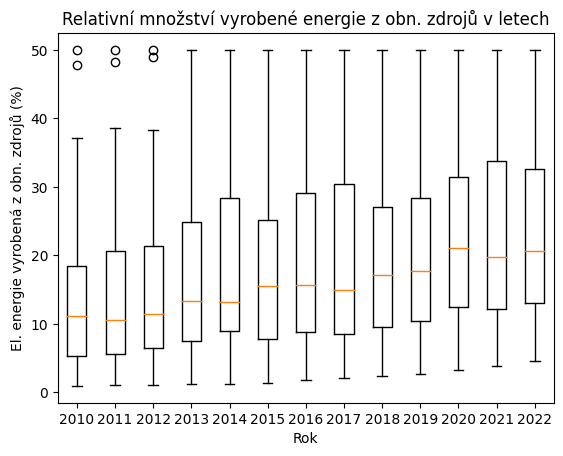

In [567]:
relative_energy_source_box(renewables,
                            title='Relativní množství vyrobené energie z obn. zdrojů v letech',
                            ylabel='El. energie vyrobená z obn. zdrojů (%)')

In [568]:
bins = [-np.inf, .07, .18, .25, .32, np.inf]
labels = ['very low or none', 'low', 'medium', 'high', 'very high']

df['renewables'] = pd.cut(x=df['renewables_perc'], bins=bins, labels=labels)
df.drop('renewables_perc', axis='columns', inplace=True)

### `temeratures`

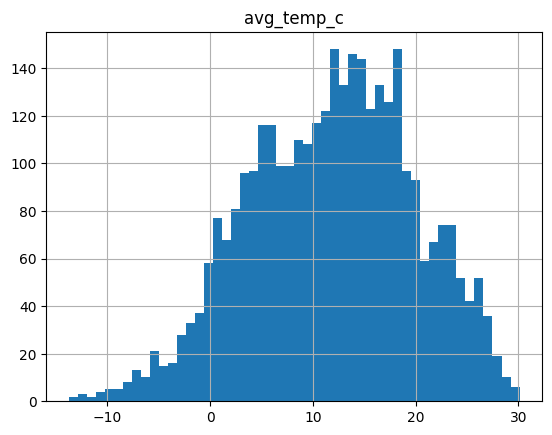

In [569]:
df.hist('avg_temp_c', bins=50)

bins = [-np.inf, 0, 10, 20, np.inf]
labels = ['very low', 'low', 'medium', 'high']

df['avg_temp'] = pd.cut(x=df['avg_temp_c'], bins=bins, labels=labels)
df.drop('avg_temp_c', axis='columns', inplace=True)

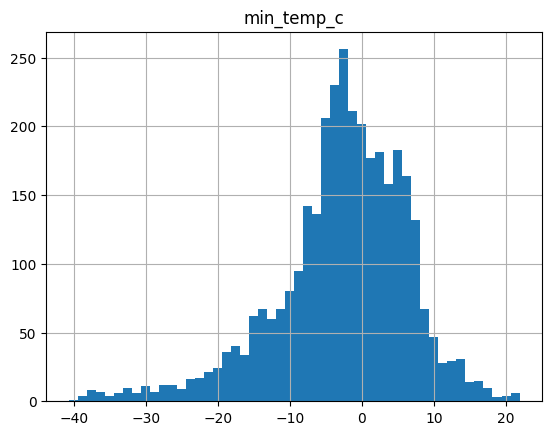

In [570]:
df.hist('min_temp_c', bins=50)

bins = [-np.inf, -15, -5, 5, 15, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['min_temp'] = pd.cut(x=df['min_temp_c'], bins=bins, labels=labels)
df.drop('min_temp_c', axis='columns', inplace=True)

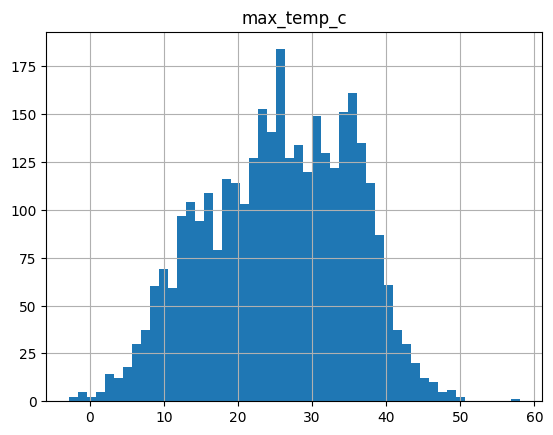

In [571]:
df.hist('max_temp_c', bins=50)

bins = [-np.inf, 15, 23, 33, 40, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['max_temp'] = pd.cut(x=df['max_temp_c'], bins=bins, labels=labels)
df.drop('max_temp_c', axis='columns', inplace=True)

### `population_density`

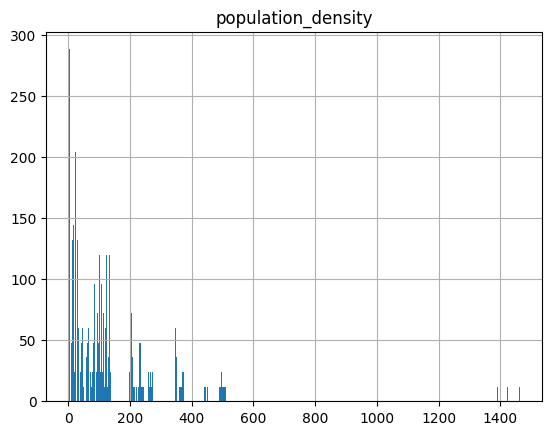

In [572]:
df.hist('population_density', bins=500)

bins = [-np.inf, 50, 100, 220, 400, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['population_density'] = pd.cut(x=df['population_density'], bins=bins, labels=labels)

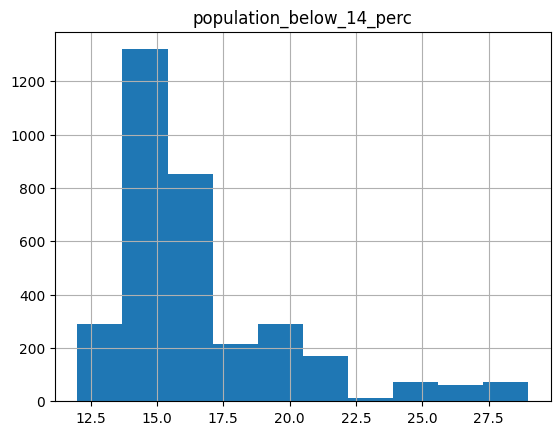

In [573]:
df.hist('population_below_14_perc', bins=10)

bins = [-np.inf, 13, 15, 17, 20, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['population_below_14'] = pd.cut(x=df['population_below_14_perc'], bins=bins, labels=labels)
df.drop('population_below_14_perc', axis='columns', inplace=True)

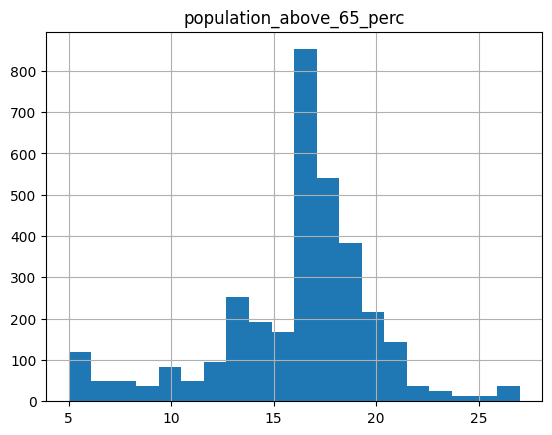

In [574]:
df.hist('population_above_65_perc', bins=20)

bins = [-np.inf, 7, 15, 18, np.inf]
labels = ['very low', 'low', 'medium', 'high']

df['population_above_65'] = pd.cut(x=df['population_above_65_perc'], bins=bins, labels=labels)
df.drop('population_above_65_perc', axis='columns', inplace=True)

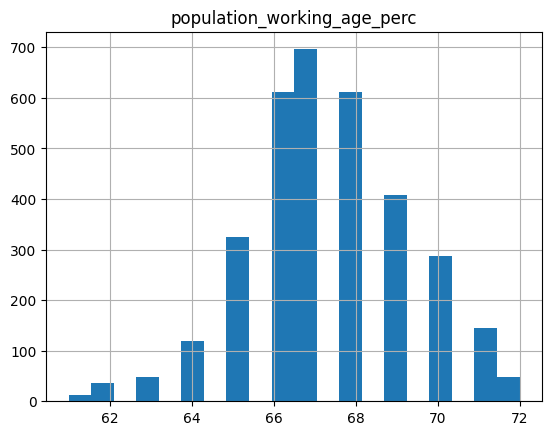

In [575]:
df.hist('population_working_age_perc', bins=20)

bins = [-np.inf, 65, 67, 69, 70, np.inf]
labels = ['very low', 'low', 'medium', 'high', 'very high']

df['population_working_age'] = pd.cut(x=df['population_working_age_perc'], bins=bins, labels=labels)
df.drop('population_working_age_perc', axis='columns', inplace=True)

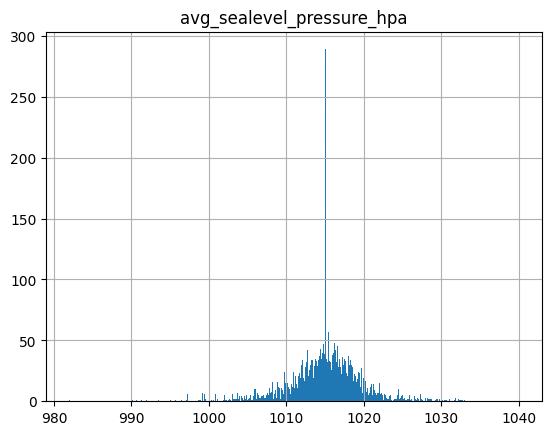

In [576]:
df.hist('avg_sealevel_pressure_hpa', bins=500)
bins = [-np.inf, 1010, 1015, 1020, np.inf]
labels = ['very low', 'low', 'medium', 'high']

df['avg_sealevel_pressure_hpa'] = pd.cut(x=df['avg_sealevel_pressure_hpa'], bins=bins, labels=labels)

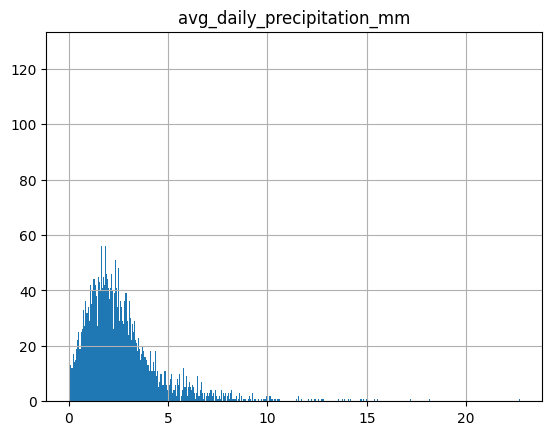

In [577]:
df.hist('avg_daily_precipitation_mm', bins=500)
bins = [-np.inf, 2, 5, np.inf]
labels = ['low', 'medium', 'high']

df['avg_daily_precipitation_mm'] = pd.cut(x=df['avg_daily_precipitation_mm'], bins=bins, labels=labels)

## Export dat

In [580]:
FILE_NAME = 'data_matrix.csv'

df.to_csv(f'data/{FILE_NAME}', separator=';')

TypeError: NDFrame.to_csv() got an unexpected keyword argument 'separator'

In [579]:
df

,country,year,month,season,avg_sealevel_pressure_hpa,avg_daily_precipitation_mm,female_perc,male_perc,population_density,coal,...,hydro,solar,wind,renewables,avg_temp,min_temp,max_temp,population_below_14,population_above_65,population_working_age
0,Argentina,2015,1,Summer,low,high,51,49,very low,very low or none,...,medium,very low or none,very low or none,low,high,medium,very high,very high,low,very low
1,Argentina,2015,2,Summer,low,high,51,49,very low,very low or none,...,medium,very low or none,very low or none,low,high,medium,high,very high,low,very low
2,Argentina,2015,3,Autumn,low,high,51,49,very low,very low or none,...,medium,very low or none,very low or none,low,high,medium,high,very high,low,very low
3,Argentina,2015,4,Autumn,medium,high,51,49,very low,very low or none,...,medium,very low or none,very low or none,low,medium,medium,high,very high,low,very low
4,Argentina,2015,5,Autumn,medium,medium,51,49,very low,very low or none,...,medium,very low or none,very low or none,low,medium,low,medium,very high,low,very low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3343,United Kingdom,2017,8,Summer,low,medium,50,50,high,very low or none,...,very low or none,high,medium,low,medium,high,medium,medium,medium,very low
3344,United Kingdom,2017,9,Autumn,low,medium,50,50,high,very low or none,...,very low or none,high,medium,low,medium,medium,low,medium,medium,very low
3345,United Kingdom,2017,10,Autumn,low,low,50,50,high,very low or none,...,very low or none,medium,medium,low,medium,medium,low,medium,medium,very low
3346,United Kingdom,2017,11,Autumn,low,low,50,50,high,low,...,very low or none,low,medium,low,low,medium,low,medium,medium,very low
